In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

In [2]:
import numpy as np
import pandas as pd

clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233', '#808080'])

(dim-red)=
# Dimensionality Reduction

Working with high dimensional data is challenging, and one common strategy is to try to reduce the amount of dimensions. This is called "dimensionality reduction" or "dimensional reduction".

## Overview of Dimensionality Reduction

### Practical uses of dimensionality reduction

There are a number of practical uses for dimensionality reduction algorithms:

* compression of data
* denoising of data
* interpretation of data
* improving model efficiency or performance

We will focus primarily on the ways that dimensionality reduction can aid in interpretation and improving model efficiency and performance, but the algorithms used for other applications are the same or similar.

### Considerations for dimensionality reduction

There are many different kinds of dimensionality reduction approaches, and when selecting between them there are a few things to consider. The relative importance of these factors will depend on the nature of the dataset and the goal of the analysis.

* Matrix rank - how many independent dimensions are there?
* Linearity of the low-dimensional subspace - are patterns linear or non-linear?
* Projection - can a new high-dimensional point be projected onto the low-dimensional map?
* Inversion - can a new low-dimensional point be projected back into high-dimensional space?
* Supervised vs. unsupervised - are the training labels used to determine the reduced dimensions?

### Assessing performance of dimensionality reduction models

It can be challenging to assess the performance of dimensional reduction models, especially when unsupervised. Nonetheless there are a few approaches that can be used. Selecting the right approach will depend on the problem, but using a variety of assessment criteria is always a good idea if possible.

#### Variance
One common idea in dimensional reduction is to assess the "retained variance" of the low-dimensional data. This is common in techniques such as PCA.

#### Distance

The "stress" function compares the distance between points $i$ and $j$ in a low-dimensional space to the distance in the full-dimensional space:

$ S(\vec{x}_{0}, \vec{x}_1, \vec{x}_2, ... \vec{x}_n) =  \left( \frac{\sum_{i=0}^n \sum_{i<j}(d_{ij} - ||x_i - x_j||)^2}{\sum_{i=0}^n \sum_{i<j} d_{ij}^2} \right)^{1/2} $


where $d_{ij}$ is the distance in the high-dimensional space and $\vec{x}$ is the vector in the low-dimensional space.

A conceptually similar way to express this is:

$\sum_i \sum_j || d(\vec{x}_i, \vec{x}_j) - d(P(\vec{x}_i), P(\vec{x}_j))||$

where $d(\vec{x}_i, \vec{x}_j)$ is the distance between $\vec{x}_i$ and $\vec{x}_j$ in the high-dimensional space, and $P(\vec{x}_j)$ is the reduced-dimension vector.

Some approaches seek to minimize these distances directly (e.g. multi-dimensional scaling), but it can also be used as an accuracy metric. We can implement this using a few helper functions. You don't need to worry about the details of this function, but can look up the documentation to see the connection.

In [3]:
from scipy.spatial.distance import pdist

def stress(X_reduced, X):
    D_red = pdist(X_reduced)
    D_tot = pdist(X)
    numerator = np.sum((D_tot - D_red)**2)
    denom = np.sum(D_tot**2)
    return np.sqrt(numerator / denom)

#### Visualization

Where possible, visualizing the data in the low-dimensional space and looking for patterns is a very powerful approach. However this becomes challenging if the low-dimensional space is $>$3 dimensions.

#### Model performance

If you have labels for the data one good approach is to construct a supervised model from both the low- and high-dimensional spaces and evaluating the accuracy of both. If the accuracy does not decrease then the key patterns are retained in the low-dimensional representation. This is also a pragmatic approach since one main use of dimensional reduction is to construct more efficient supervised models.

## Principal Component Analysis (PCA)

PCA should already be familiar, but we will take a closer look in this lesson. As a quick refresher the principal component analysis is obtained via the eigenvalues of the covariance matrix. First, let's take a look at the MNIST data since we haven't worked with it yet. First we need to re-import it:

In [4]:
import pandas as pd
from sklearn.datasets import load_digits

digits = load_digits()
print("Digits data shape: {}".format(digits.data.shape))
print("Digits output shape: {}".format(digits.target.shape))
X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

Digits data shape: (1797, 64)
Digits output shape: (1797,)


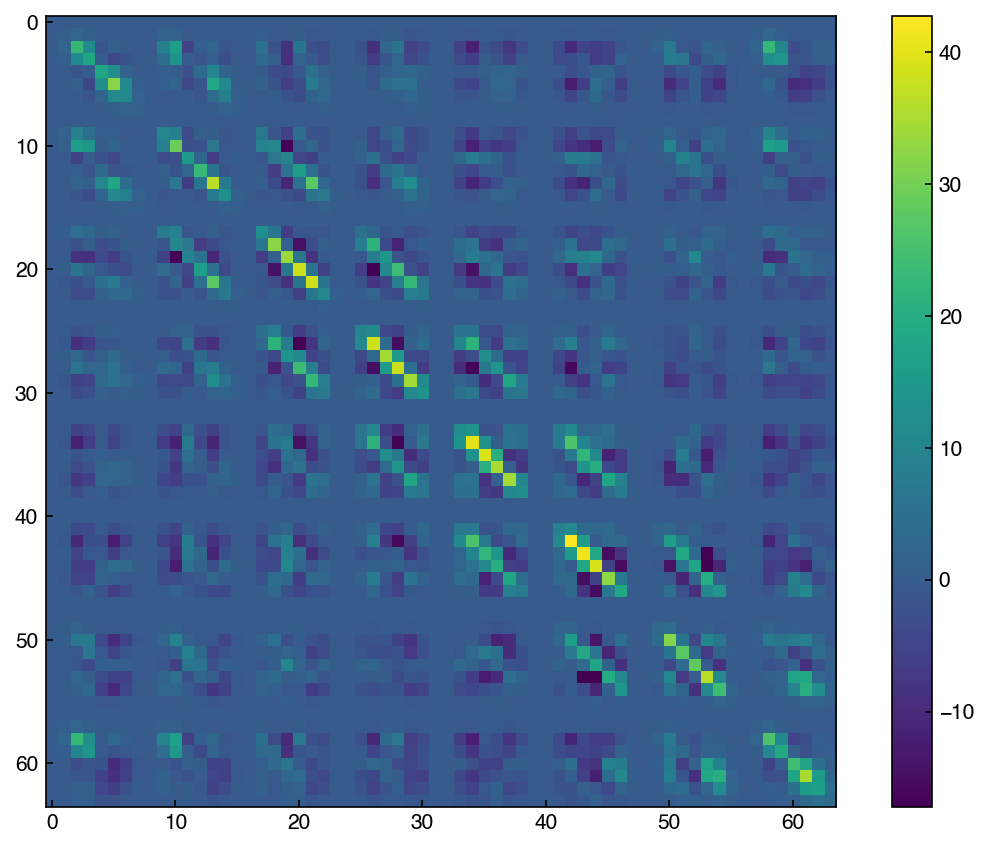

In [5]:
C = np.cov(X_mnist.T)
fig,ax = plt.subplots()
c = ax.imshow(C)
fig.colorbar(c, ax = ax);

### Discussion: How is this different from the correlation matrix? Why are there "blocks" in matrix?
> The covariance matrix takes account of the correlation as well as the units. For the MNIST dataset, the unit is not an issue since all pixels have the same unit, which is a pixel intensity ranging from 0 to 16.

> Blocks mean the correlation to their neighbors, and you can see that the blocks are mostly 8x8 matrix. This indicates that this 64x64 covariance matrix came from 8x8 image.

In [6]:
eig_vals, eig_vecs = np.linalg.eig(C)
eig_vecs = eig_vecs.T #<- note that the eigenvectors are the *columns* by default

These eigenvalues and eigenvectors are the same as the "principal component values" and "principal component vectors". Technically, we need to also sort the vectors by the size of the eigenvalues (since the eigenvalues reperesent the variance in each direction). 

In [7]:
sorted_idxs = np.argsort(eig_vals) #this gives us the list of indices from smallest to largest
sorted_idxs = list(sorted_idxs)
sorted_idxs.reverse() #this goes from largest to smallest
eig_vals = eig_vals[sorted_idxs] #re-sort values
eig_vecs = eig_vecs[sorted_idxs, :] #re-sort vectors

Now The vectors are sorted from most variance (largest eigenvalue) to least. We can actually visualize the principal component vectors as images, similar to how we can view any entry in the MNIST dataset as an image:

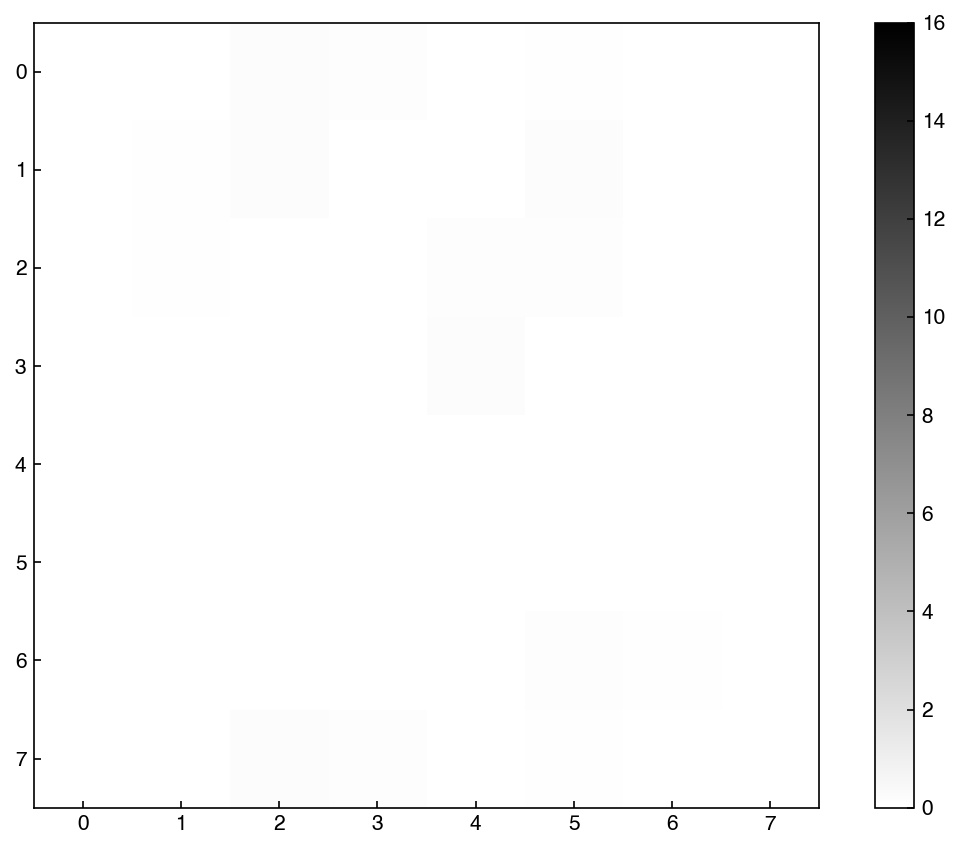

In [8]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    colormap = ax.imshow(img, cmap='binary', vmin=0, vmax=16)
    ax.get_figure().colorbar(colormap, ax=ax)
    
show_image(eig_vecs, 0)

We can see that this is clearly not random, but has some patterns associated with digits. This is the vector along which there is the most variance.

### Example: Find the rank of the covariance matrix

Hint: Remember the definition of rank in term of eigenvalues.

In [9]:
print('Rank of the covariance matrix: {}'.format(np.linalg.matrix_rank(C)))
print(eig_vals)

Rank of the covariance matrix: 61
[1.79006930e+02 1.63717747e+02 1.41788439e+02 1.01100375e+02
 6.95131656e+01 5.91085249e+01 5.18845391e+01 4.40151067e+01
 4.03109953e+01 3.70117984e+01 2.85190412e+01 2.73211698e+01
 2.19014881e+01 2.13243565e+01 1.76367222e+01 1.69468639e+01
 1.58513899e+01 1.50044602e+01 1.22344732e+01 1.08868593e+01
 1.06935663e+01 9.58259779e+00 9.22640260e+00 8.69036872e+00
 8.36561190e+00 7.16577961e+00 6.91973881e+00 6.19295508e+00
 5.88499123e+00 5.15586690e+00 4.49129656e+00 4.24687799e+00
 4.04743883e+00 3.94340334e+00 3.70647245e+00 3.53165306e+00
 3.08457409e+00 2.73780002e+00 2.67210896e+00 2.54170563e+00
 2.28298744e+00 1.90724229e+00 1.81716569e+00 1.68996439e+00
 1.40197220e+00 1.29221888e+00 1.15893419e+00 9.31220008e-01
 6.69850594e-01 4.86065217e-01 2.52350432e-01 9.91527944e-02
 6.31307848e-02 6.07377581e-02 3.96662297e-02 1.49505636e-02
 8.47307261e-03 3.62365957e-03 1.27705113e-03 6.61270906e-04
 4.12223305e-04 0.00000000e+00 0.00000000e+00 0.000

Note that so far we have not reduced the dimensionality at all. We simply found an orthonormal set of vectors that are aligned with the data and rotated the data along these new "axes". For dimensional reduction, we can think of PCA from the perspective of an objective function. The objective function for PCA is:

$||\underline{\underline{X}} - \underline{\underline{A}}||_F$

where $||\underline{\underline{M}}||_F = \sum_i \sum_j M_{ij}^2$ is the "Frobenius norm" and $\underline{\underline{A}}$ is a "low rank" approximation of $\underline{\underline{X}}$.

Obviously if this objective function is simply minimized for all the elements of $\underline{\underline{A}}$ it will give us $\underline{\underline{X}}$, which is rather trivial. The key is that we apply a constraint on the rank:

$\min_{\underline{\underline{A}}} ||\underline{\underline{X}} - \underline{\underline{A}}||_F$ subject to $rank(\underline{\underline{A}}) \leq k$

In other words we are looking for the closest rank-$k$ matrix to the original matrix $\underline{\underline{X}}$. 

Note: We will not derive the connection between this minimization problem and the covariance matrix eigenvalues here, but details are available in Hastie & Tibshirani Sec. 14.5.

In practice, we can find the low-rank approximation by only keeping the highest $k$ eigenvalues/vectors:

In [10]:
k = 20
projector = eig_vecs[:k, :].T
print(projector.shape)
print(X_mnist.shape)
X_k = np.dot(X_mnist,projector)
print(X_k.shape)

(64, 20)
(1797, 64)
(1797, 20)


We see that the new dataset has the same number of points (1797) but now only has 20 features. We can assess the quality of the reduced-dimensional dataset by comparing the amount of variance, remembering that the total variance is the sum of the variance along each principal component vector:

In [11]:
print('Retained variance: {}'.format(sum(eig_vals[:k])/sum(eig_vals)))

Retained variance: 0.8943031165985261


We can also create a "scree plot" that shows the amount of retained variance as a function of number of componenets:

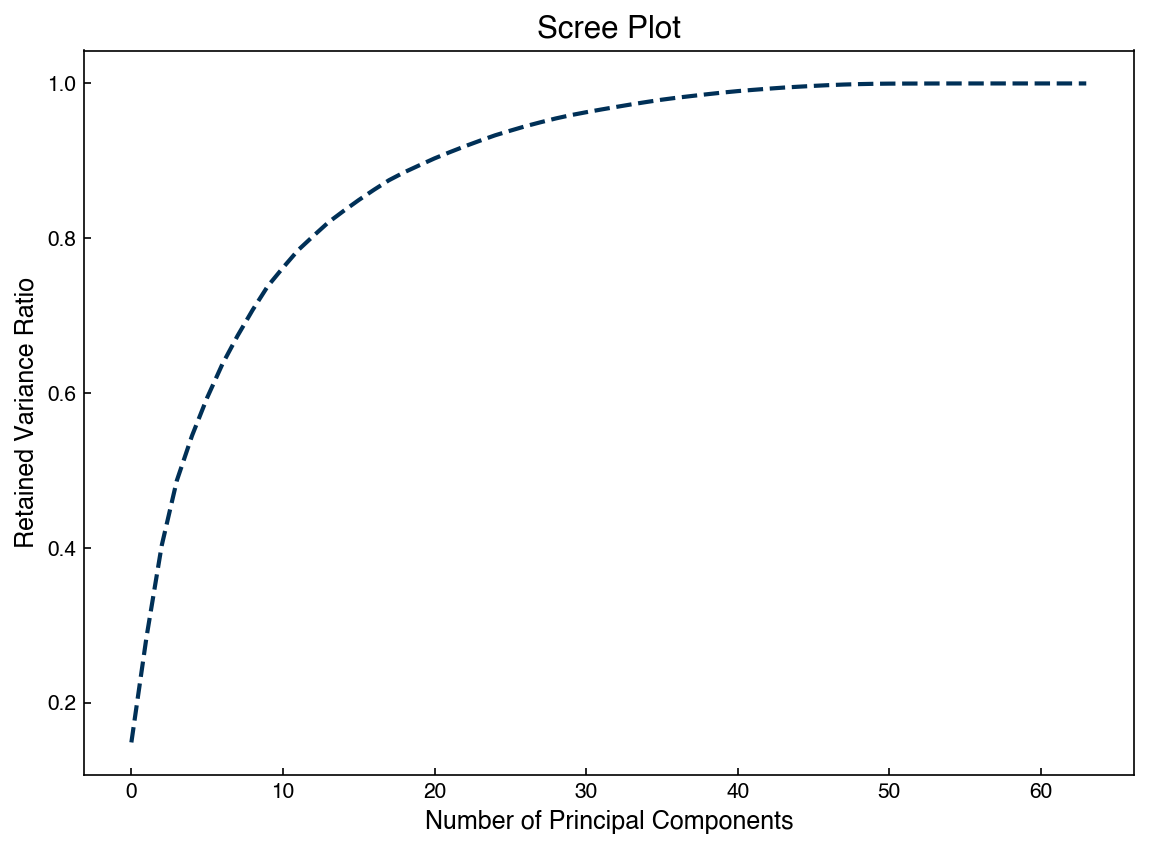

In [12]:
fig, ax = plt.subplots()
N = len(eig_vals)
ax.plot(range(N), np.cumsum(eig_vals)/sum(eig_vals))
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Retained Variance Ratio')
ax.set_title('Scree Plot');

We can also assess the "stress" for the reduced dimension matrix as a function of number of dimensions:

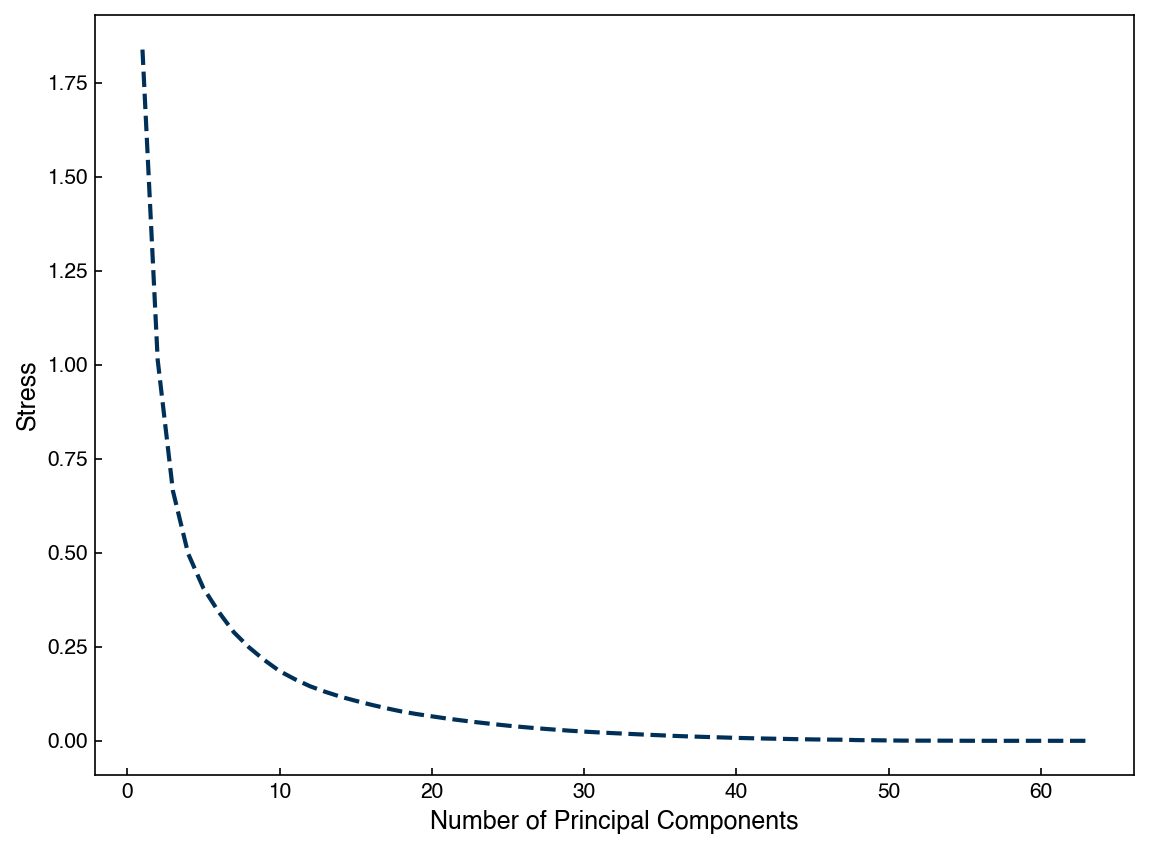

In [13]:
stresses = []
for k in range(1,N):
    projector = eig_vecs[:k, :].T
    X_k = np.dot(X_mnist,projector)
    stresses.append(stress(X_mnist, X_k))

fig, ax = plt.subplots()
ax.plot(range(1,N), stresses)
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Stress');

We can also project onto 2 dimensions and visualize the data:

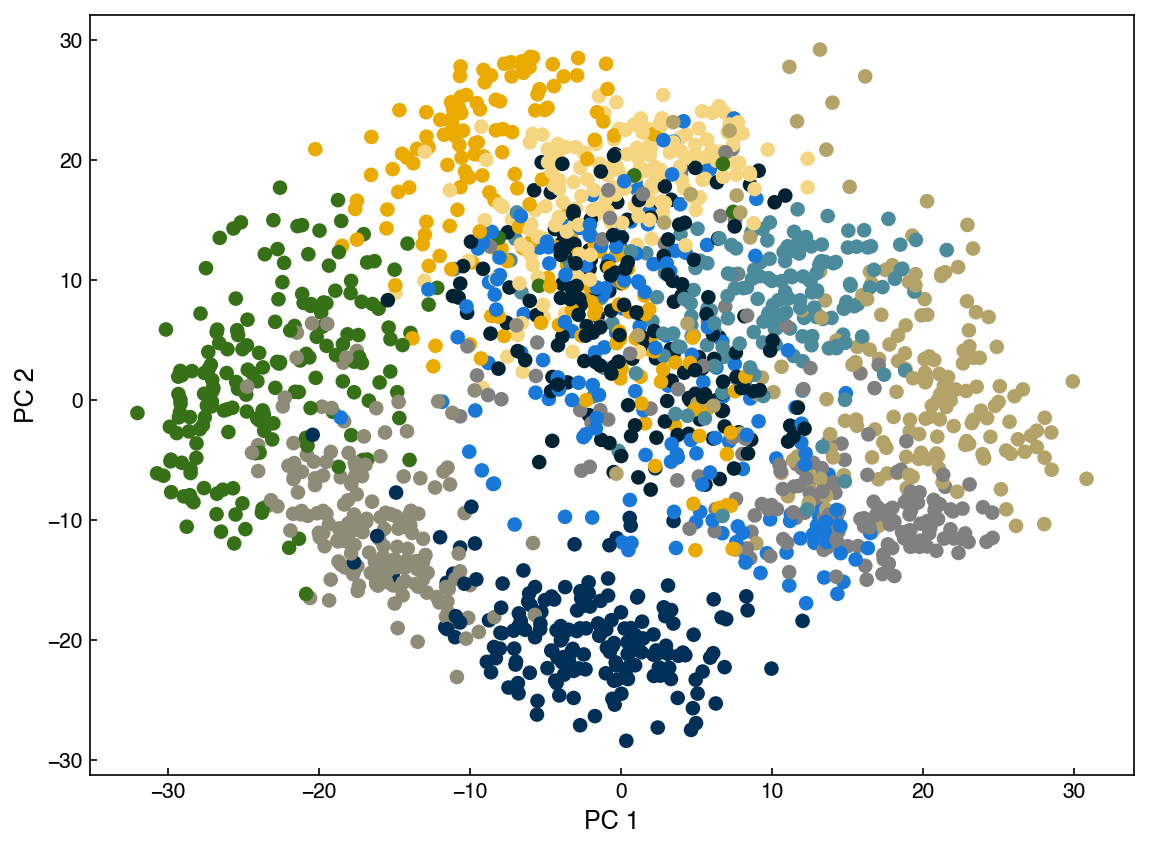

In [14]:
k = 2
projector = eig_vecs[:k, :].T
X_k = np.dot(X_mnist, projector)

fig,ax = plt.subplots()

ax.scatter(X_k[:, 0], X_k[:, 1], c = clrs[y_mnist])
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2');

Each different color in this plot represents a different digit identity. We can add some labels to make it easier to interpret:

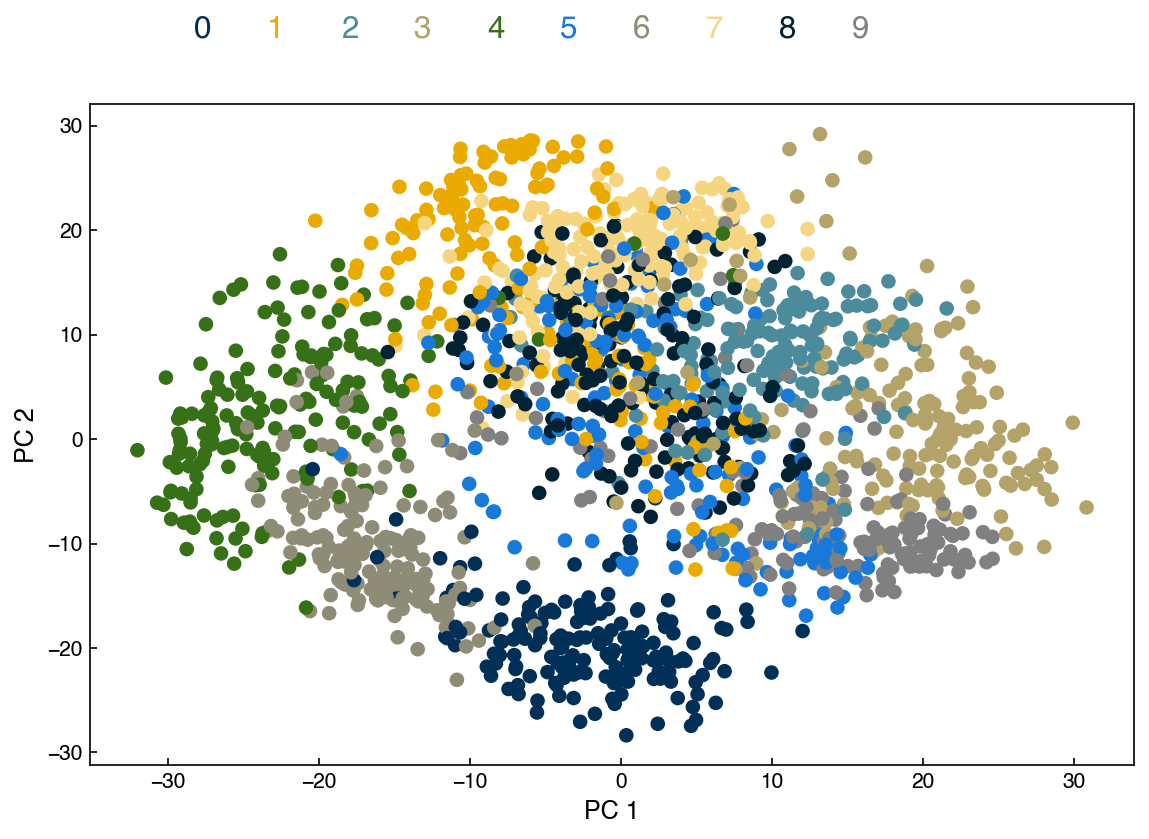

In [15]:
def add_labels(ax, colors = clrs):
    xpos = 0.1
    for label in range(0, 10):
        c = colors[label]
        ax.annotate(str(label), xy = [xpos, 1.1], xycoords = 'axes fraction', color = c, size = 15)
        xpos += 0.07

add_labels(ax)
fig

Remember that PCA is *unsupervised*, so even though we are visualizing the labels here we did not use them to find the principal components. Another interesting feature of PCA is that it is *invertible*. We can select a point in the low-dimensional space and project it back to the high-dimensional space:

In [16]:
X_reconstructed = np.dot(projector, X_k.T).T

print(X_reconstructed.shape)

(1797, 64)


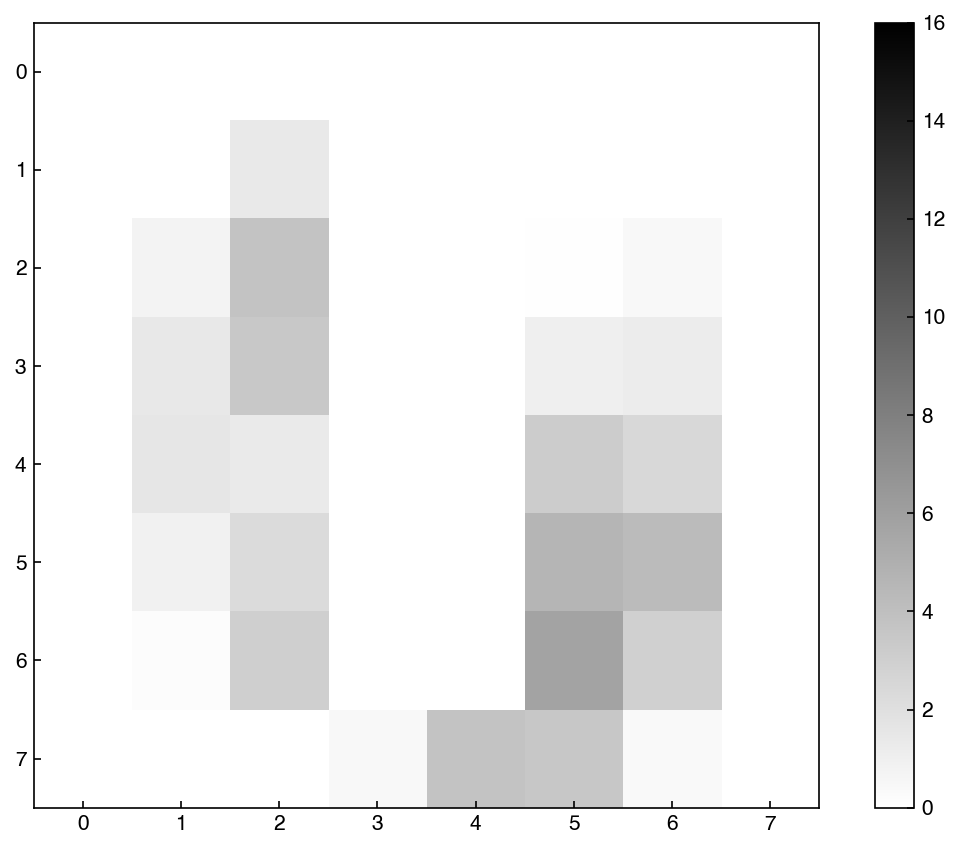

In [17]:
show_image(X_reconstructed, 0)

We can see how this changes as we increase the amount of dimensions:

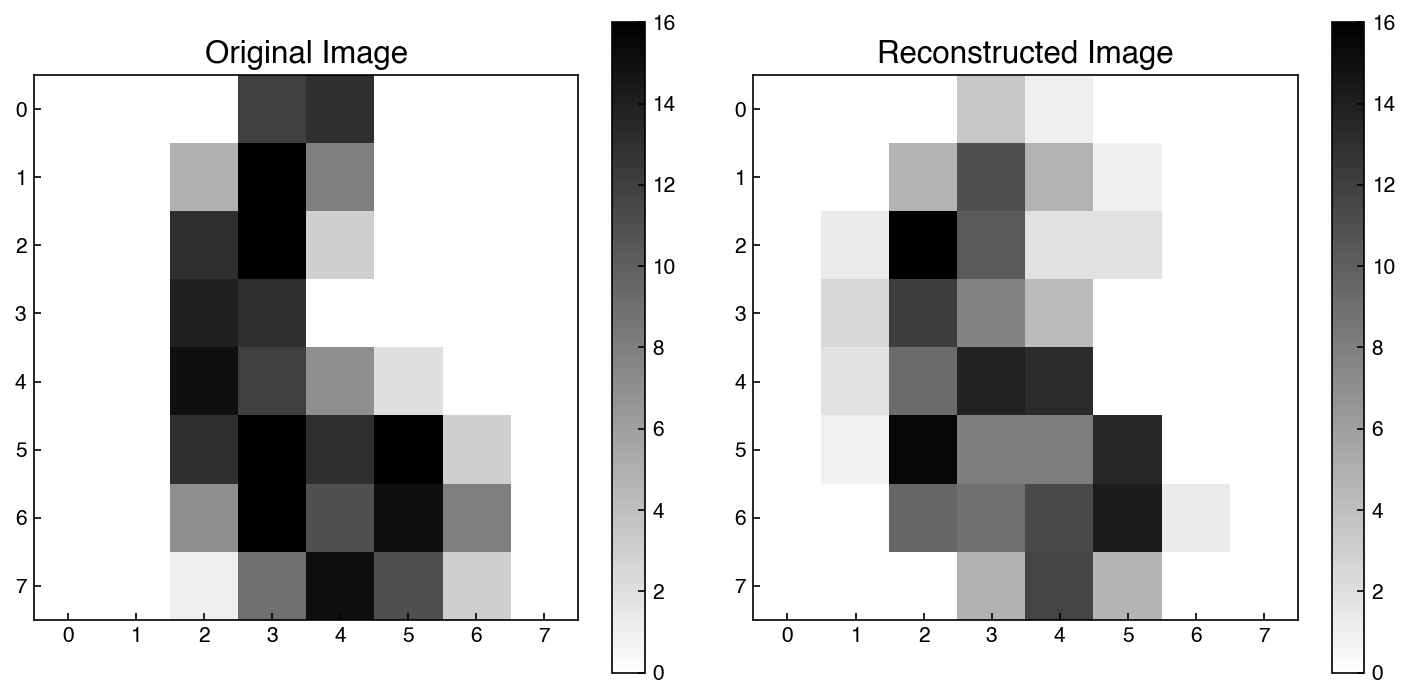

In [18]:
k = 10
projector = eig_vecs[:k, :].T
X_k = np.dot(X_mnist, projector)
X_reconstructed = np.dot(projector, X_k.T).T

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
index = 6
show_image(X_mnist, index, ax = axes[0])
show_image(X_reconstructed, index, ax = axes[1])
axes[0].set_title('Original Image')
axes[1].set_title('Reconstructed Image');

This is an example of how dimensionality reduction could be used for image compression or de-noising. If we only store the low-rank approximation it will require less memory. Similarly, the reconstructed version may actually have less noise, since the noise will typically be random (and therefore it will be dropped in the reconstruction).

Finally, we can come up with new points that aren't even in the original dataset. For example, we can come up with an "average" of a given digit:

(10,)


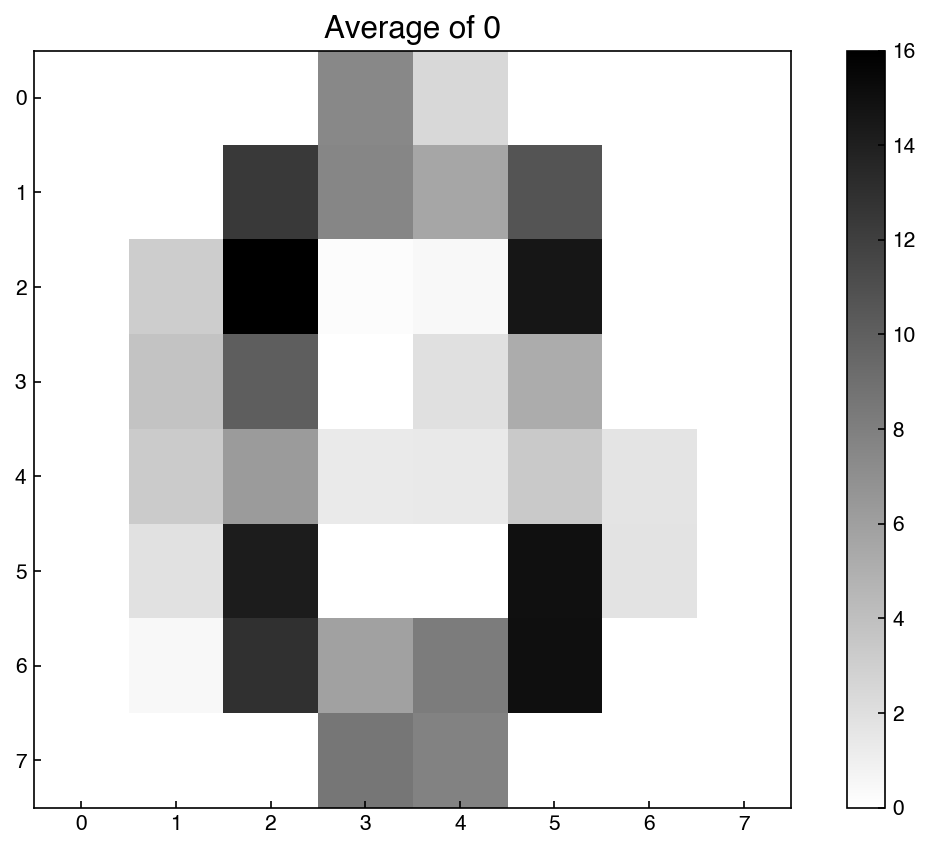

In [19]:
digit_idxs = y_mnist == 0
X_lowD_digit = X_k[digit_idxs].mean(axis = 0)
print(X_lowD_digit.shape)

X_reconstructed = np.dot(projector, X_lowD_digit.T).T
X_reconstructed = X_reconstructed.reshape(1, -1)

fig, ax = plt.subplots()
show_image(X_reconstructed, 0, ax = ax)
ax.set_title('Average of 0');

This is an "average" example of a 0 based on the 10-dimensional representation of the digits.

### Example: Find the "average" 10-dimensional vector for an "8"

Use PCA to project the data onto 10 dimensions, then select the points labeled as 8 and take the average. 

In [20]:
digit_idxs = y_mnist == 8
X_lowD_8 = X_k[digit_idxs].mean(axis = 0)
print(X_lowD_digit)

[ -2.28714734 -19.4125737    2.12896496   5.33976559   9.93898522
 -23.36268307  -8.83730922  10.23672289   7.4251487  -33.22891825]


From here on we will rely on the `scikit-learn` PCA implementation to reduce the amount of code needed and speed things up:

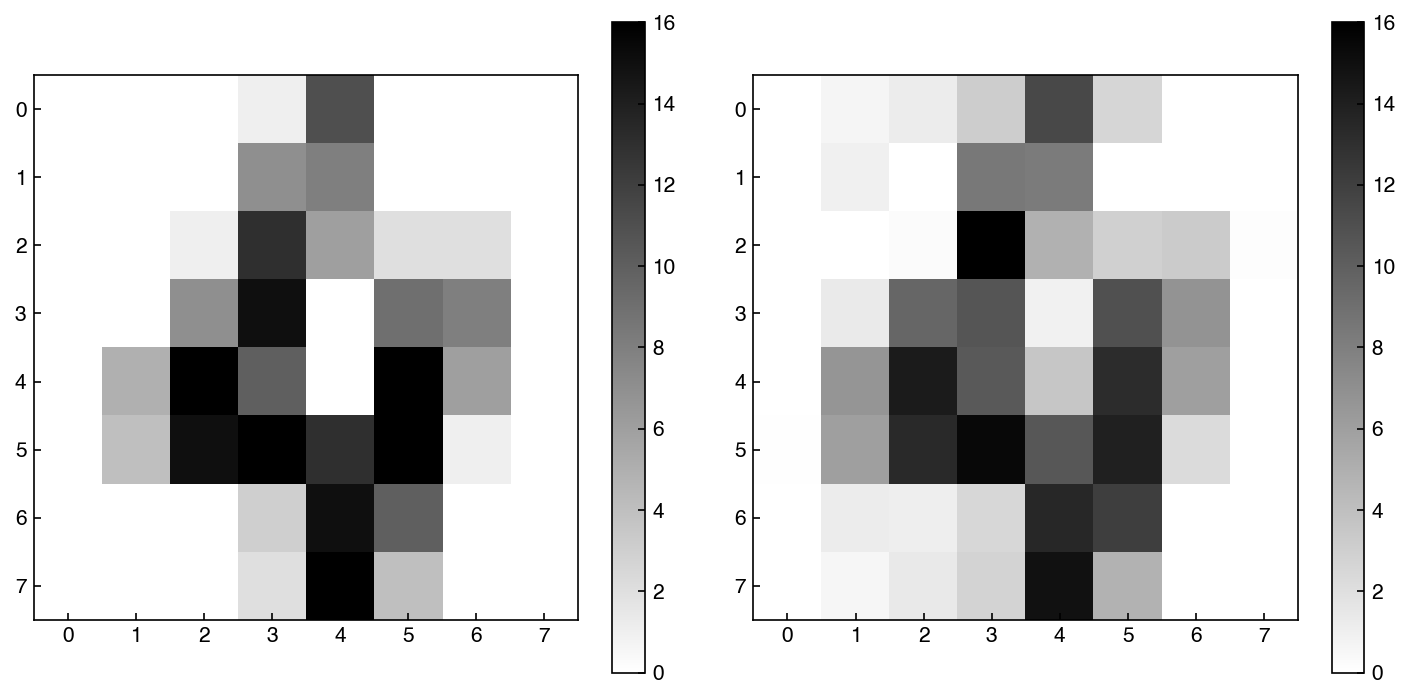

In [21]:
from sklearn.decomposition import PCA

k = 20
pca_model = PCA(n_components = k)
pca_model.fit(X_mnist)
X_k = pca_model.transform(X_mnist)
X_reconstructed = pca_model.inverse_transform(X_k)

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
index = 4
show_image(X_mnist, index, ax = axes[0])
show_image(X_reconstructed, index, ax = axes[1])

We can extract the same outputs from `scikit-learn` model, but they have different names as usual. For example, we can find the explained variance ratio:

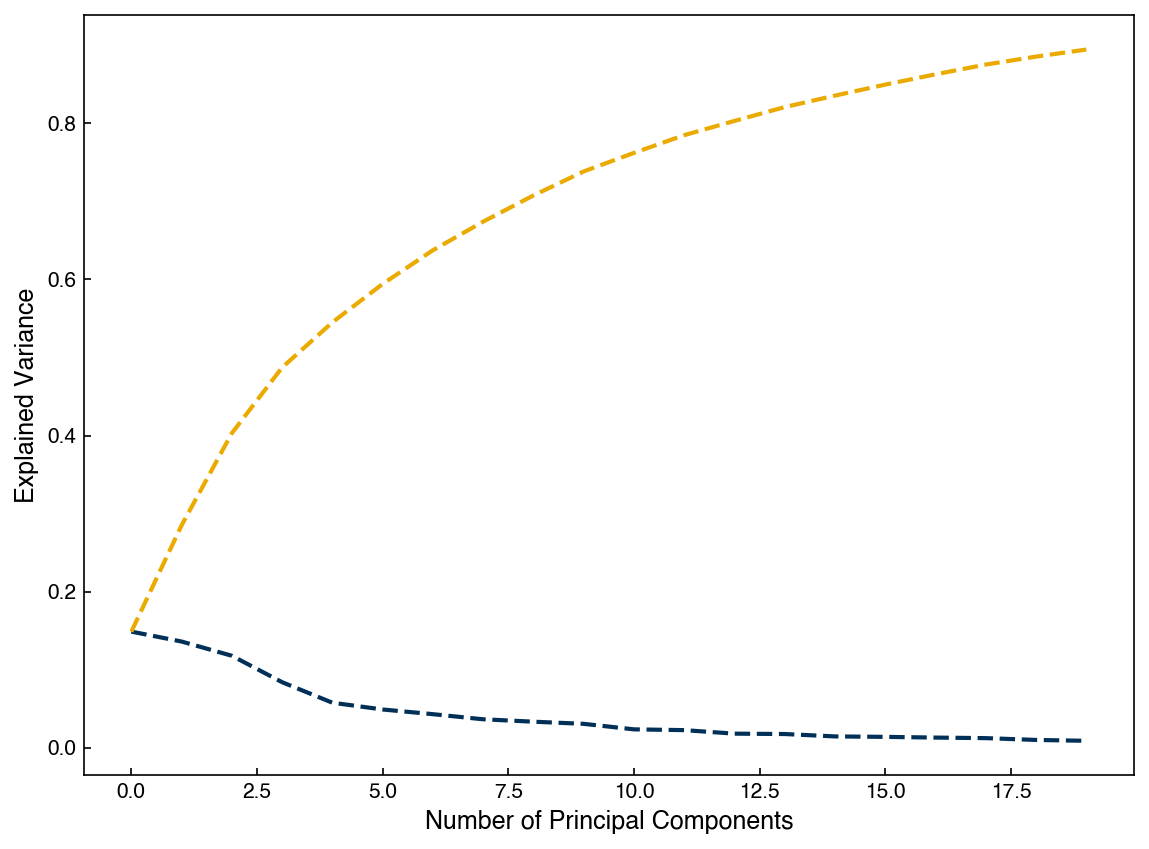

In [22]:
evr = pca_model.explained_variance_ratio_
fig, ax = plt.subplots()
ax.plot(range(len(evr)), evr)
ax.plot(range(len(evr)), np.cumsum(evr))
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Explained Variance');

As usual, you can find the other outputs and methods in [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In conclusion, PCA is one of the most widely used techniques in dimensional reduction because it is:

* Unsupervised - We did not use the labels to determine the statistics
* Projectable - It is easy to project a new data point into the reduced dimensional space
* Invertible - It is easy to move from the low-dimensional space to the high dimensional space

However, its weakness is that it is linear in the original space. It does not do well with non-linear patterns.

## Kernel PCA

The solution to non-linearity in PCA is a familiar one: using a "kernel" to perform PCA in an even-higher dimensional space that captures non-linearities. The concept here is that rather than using the covariance matrix the eigenvalues of a "kernel matrix" are used:

$K_{ij} = \kappa(\vec{x}_i, \vec{x}_j)$ where $\kappa$ is a kernel function such as the radial basis function:

$\kappa_{rbf}(\vec{x}_i, \vec{x}_j) = \exp(-\gamma ||\vec{x}_i - \vec{x}_j||^2)$

We will not go into the details, but instead show an example of how it works with the `scikit-learn` implementation. We will revisit our "moons" dataset to see how it works:

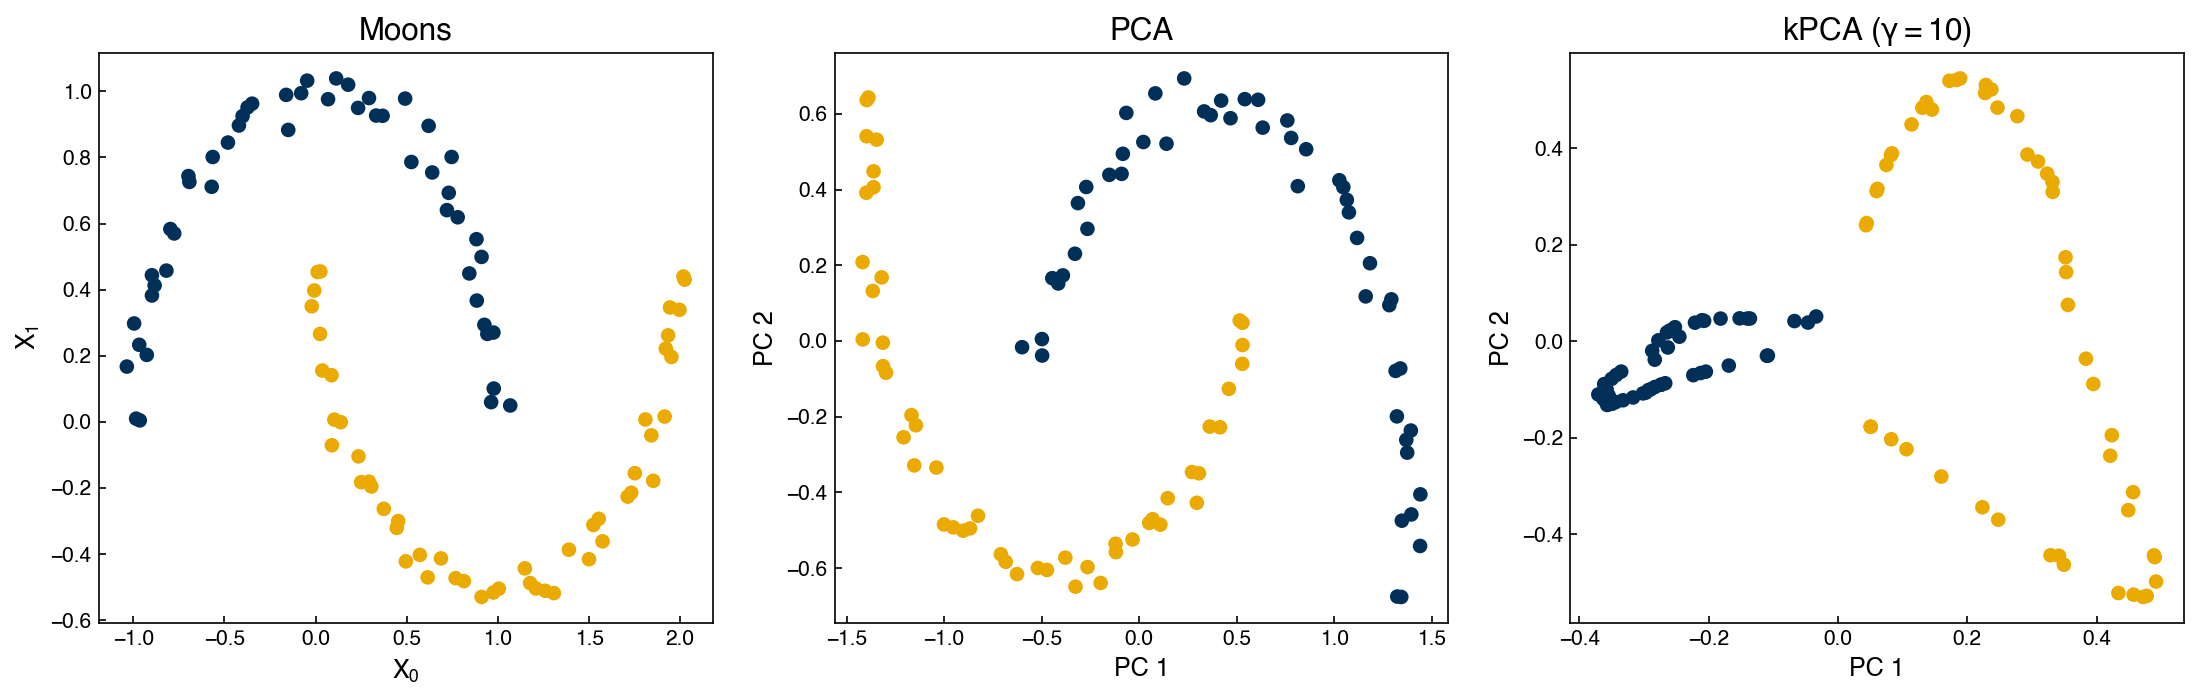

In [23]:
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA, PCA

X_m, y_m = make_moons(n_samples = 100, random_state = 0, noise = 0.04)

k = 2
gamma = 10
lPCA = PCA(n_components = k)
kPCA = KernelPCA(n_components = k, kernel = 'rbf', gamma = gamma, fit_inverse_transform = True)

lPCA.fit(X_m)
X_PCA = lPCA.transform(X_m)

kPCA.fit(X_m)
X_kPCA = kPCA.transform(X_m)

fig,axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].scatter(X_m[:, 0], X_m[:, 1], c = clrs[y_m])
axes[0].set_title('Moons')
axes[0].set_xlabel('$X_0$')
axes[0].set_ylabel('$X_1$')
axes[1].scatter(X_PCA[:, 0], X_PCA[:, 1], c = clrs[y_m])
axes[1].set_title('PCA')
axes[1].set_xlabel('PC 1')
axes[1].set_ylabel('PC 2')
axes[2].scatter(X_kPCA[:, 0], X_kPCA[:, 1], c = clrs[y_m])
axes[2].set_title('kPCA ($\gamma=${})'.format(gamma))
axes[2].set_xlabel('PC 1')
axes[2].set_ylabel('PC 2');

We can see that while PCA fails to separate the two datasets, kernel PCA is successful! However, we had to choose a hyperparameter ($\gamma$).

Kernel PCA is also invertible:

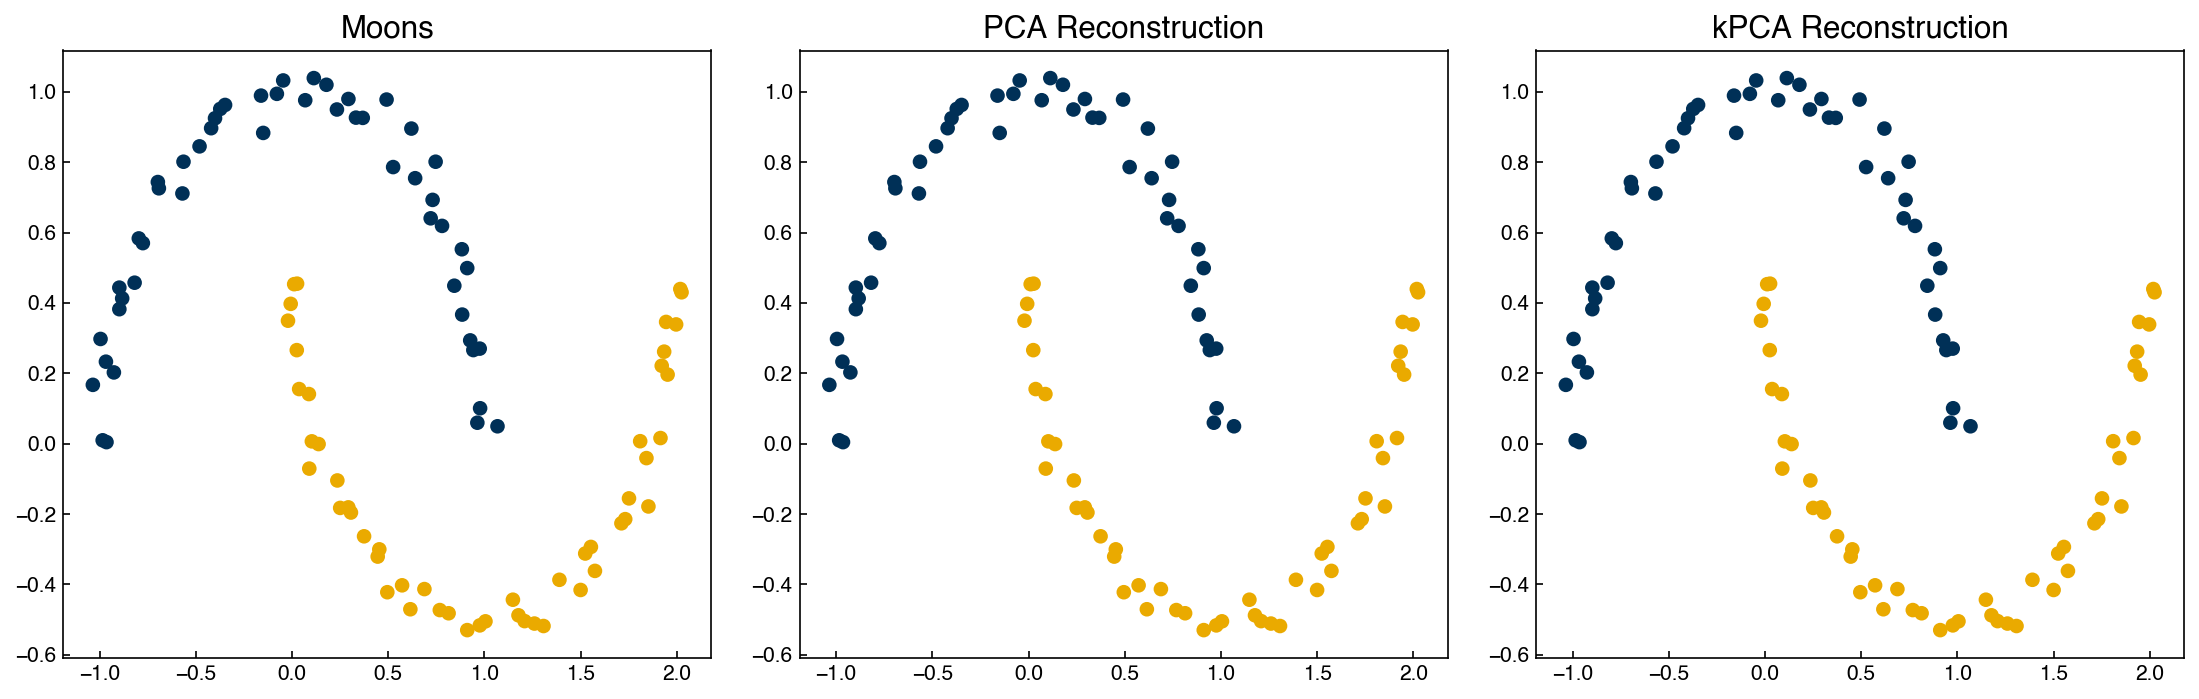

In [24]:
X_PCA_reconstruct = lPCA.inverse_transform(X_PCA)
X_kPCA_reconstruct = kPCA.inverse_transform(X_kPCA)

fig,axes = plt.subplots(1, 3, figsize = (15, 5))

axes[0].scatter(X_m[:, 0], X_m[:, 1], c = clrs[y_m])
axes[0].set_title('Moons')

axes[1].scatter(X_PCA_reconstruct[:, 0], X_PCA_reconstruct[:, 1], c = clrs[y_m])
axes[1].set_title('PCA Reconstruction')

axes[2].scatter(X_kPCA_reconstruct[:, 0], X_kPCA_reconstruct[:, 1], c = clrs[y_m])
axes[2].set_title('kPCA Reconstruction');

### Other PCA variants

PCA is one of the most powerful dimensional reduction techniques and has many other variants. We will not go into the details, but a few worth mentioning are:

* Robust PCA - good for cases where there is sparse data and/or large errors/outliers
* Partial least squares - supervised regression-based PCA that maximizes covariance between input and output
* Linear discriminant analysis - supervised classification-based PCA that maximizes inter-class variance

We will revisit partial least squares and linear discriminant analysis later.

## Other dimensional reduction approaches

There are many other techniques that can be applied for dimensional reduction. Here we will briefly introduce two concepts: manifold learning and autoencoding.

### Manifold learning

Manifold learning approaches utilize distance metrics between points to define their similarity, and then seek to minimize the difference between distance metrics in the high- and low-dimensional spaces. The advantage of distance metrics over variance is that the local structure of data (distances between points) can be more easily exploited. This makes manifold learning techniques much better suited for highly non-linear datasets.

One prototype manifold learning technique is multi-dimensional scaling. The principle is that the "stress" metric which we introduced earlier is directly minimized. The stress is given by:

$S(\vec{x}_{0}, \vec{x}_1, \vec{x}_2, ... \vec{x}_n) =  \left(\frac{\sum_{i=0}^n \sum_{i < j}(d_{ij} - ||x_i - x_j||)^2}{\sum_{i=0}^n \sum_{i < j} d_{ij}^2}\right)^{1/2}$

where $d_{ij}$ is the distance in the high-dimensional space and $\vec{x}$ is the vector in the low-dimensional space. A typical choice is to use the Euclidean distance to compute $d_{ij}$, but there are variants of MDS that use other distance metrics. For example "non-metric" MDS uses distances based on ordering between different points, so that the relative ordering of distances is favored over the numerical value of distances.

The optimization problem is rather challenging, so we will just use the `scikit-learn` implementation to see how MDS works for the hand-written digits:

Stress MDS:  0.3476710001843273
Stress PCA:  0.5405344832395483


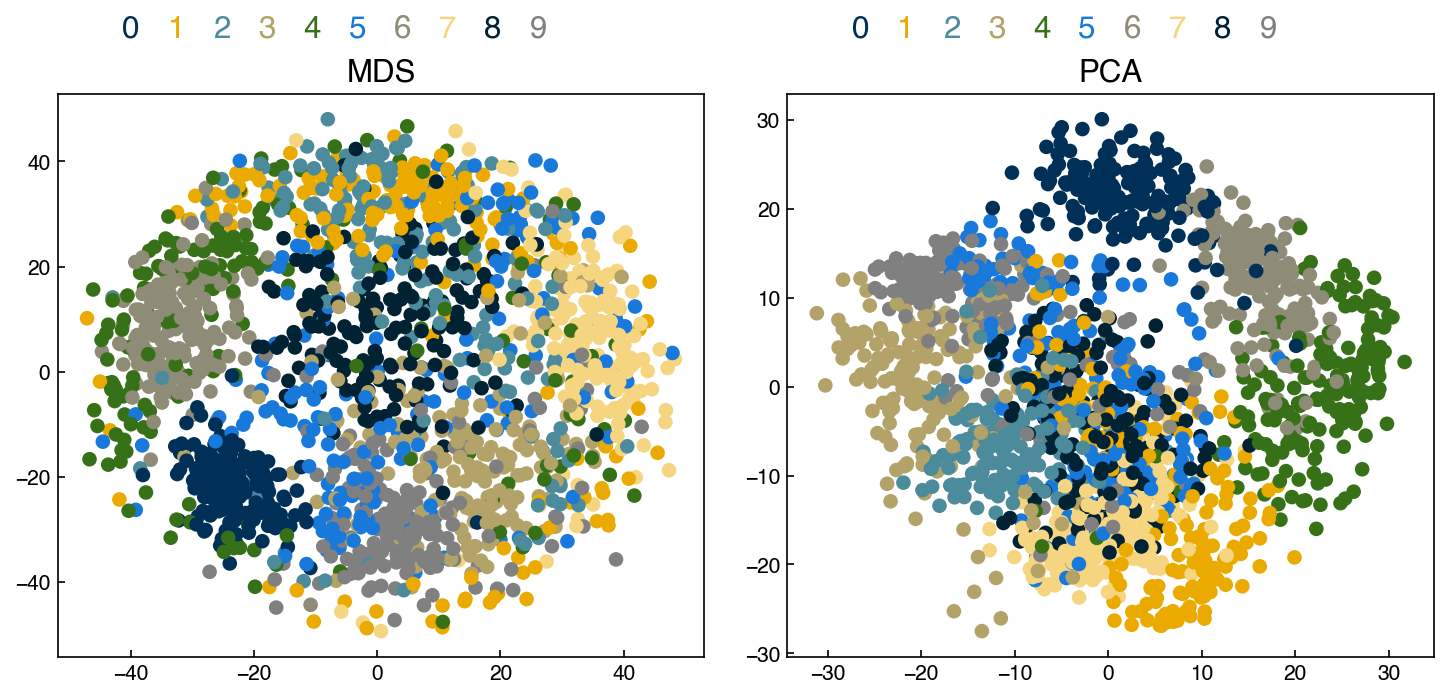

In [25]:
from sklearn.manifold import MDS

k = 2
mds = MDS(n_components = k, n_init = 1, max_iter = 100) #<- note that we need to give some max_iteration and initial guess parameters since this is iterative
X_mds = mds.fit_transform(X_mnist) #<- note that there is no transform method. What does this mean?


pca_model = PCA(n_components = k)
X_k = pca_model.fit_transform(X_mnist)

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].scatter(X_mds[:, 0], X_mds[:, 1], c = clrs[y_mnist])
add_labels(axes[0])
axes[0].set_title('MDS')

axes[1].scatter(X_k[:, 0], X_k[:, 1], c = clrs[y_mnist])
add_labels(axes[1])
axes[1].set_title('PCA')

print('Stress MDS: ', stress(X_mds, X_mnist))
print('Stress PCA: ', stress(X_k, X_mnist))

There are clearly some clusters, but the separation is not much better than PCA. Adding more iterations or initial configurations may improve things.

Another popular manifold-based method is tSNE, or t-distribution stochastic neighbor embedding. This uses a probabilistic similarity metric based on the t-distribution, which makes it somewhat better suited to retain both local and global structure. The details of this are well beyond this course, but we can see how it performs:

Stress:  0.7890299639828614


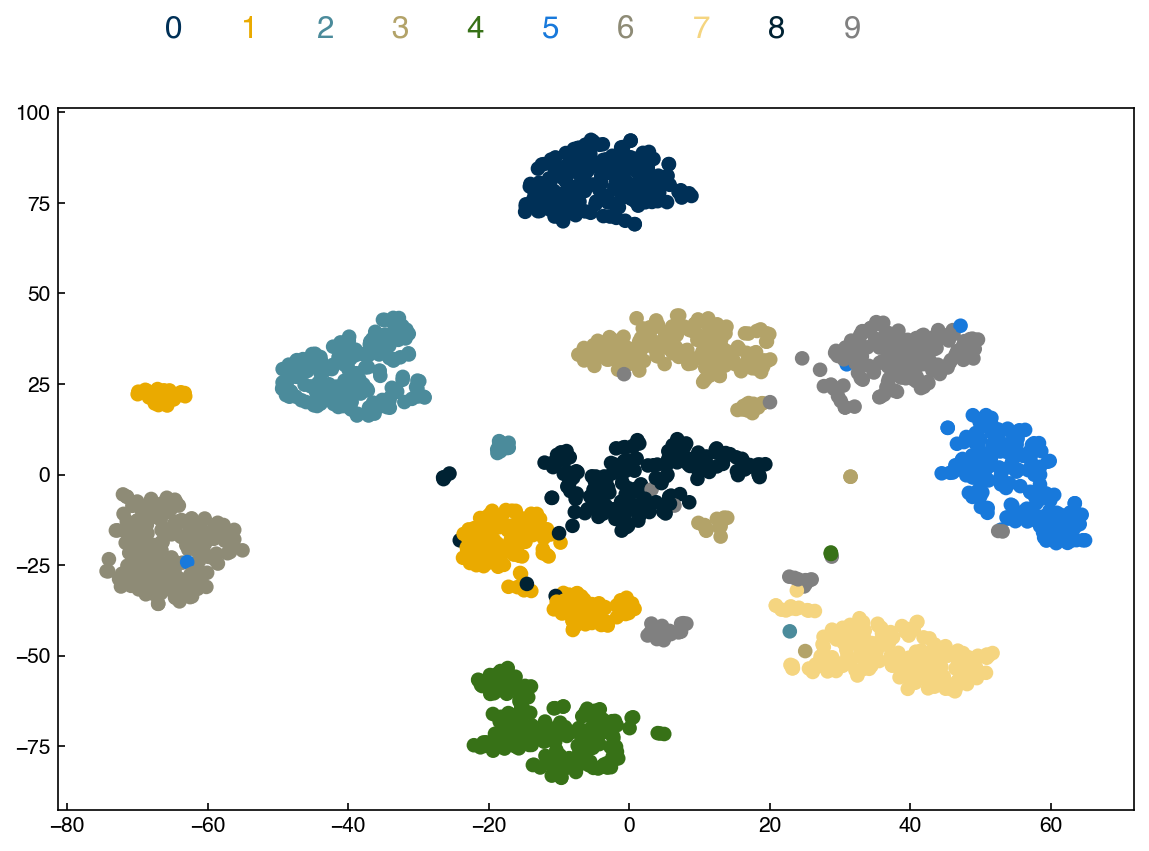

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 30.0, 
            early_exaggeration = 12.0, 
            learning_rate = 200.0, 
            n_iter = 1000,
            init = 'random',
            method = 'exact')

X_tsne = tsne.fit_transform(X_mnist)

fig, ax = plt.subplots()
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c = clrs[y_mnist])
add_labels(ax)
print('Stress: ', stress(X_tsne, X_mnist))

There is slightly better separation than MDS and PCA, but still considerable overlap. There are also many additional hyper-parameters that don't have clear meaning (e.g. "perplexity"), and the outcome will depend on the initial guesses and the algorithms used. While tSNE can be powerful, it also typically requires substantial effort.

Some other common manifold-based techniques include:

* Isomap
* Locally linear embedding (LLE)
* Spectral embedding
* Local tangent space alignment (LTSA)

A comparison:

Manifold techniques can give powerful insight into the high-dimensional structure of data; however, most suffer from several key disadvantages:

* Not projectable - the low dimensional representation only applies to the training points.
* Not invertible - no way to move back to high-dimensional space
* Slow - manifold techniques use distance matrices and hence tend to scale as $N^2$

For these reasons manifold techniques are best for providing insight into the structure of the data, but usually need to be combined with other dimensional reduction approaches for model construction.

### Autoencoding

![autoencoder](./autoencoder.png)

The final approach we will discuss is "autoencoding", which is the use of neural networks for dimensional reduction. This is a relatively new approach without any implementation in scikit-learn, but it is conceptually different from others so it is included here.

The idea is that you train a neural network with the same data as inputs and outputs, but use an intermediate hidden layer (or layers) with dimensionality smaller than the original data. This forces the data through a "bottleneck" where it is represented in a low-dimensional form. 

This has numerous advantages:

* projectable and invertible - the link between the high/low dimensional representation is defined by the neural net
* fast and scalable - neural networks are computationally efficient
* non-linear and unsupervised - the autoencoder learns the non-linear manifold without needing labels

However, the typical cautions of neural networks apply:

* extremely large training datasets needed
* architecture and hyperparameters need to be tuned/selected
* no intuitive link between low- and high-dimensional representations

This is a field of research on its own, but worth being aware of nonetheless.